# "Cross-validation" des modèles

In [ ]:
learning_rate = 0.05
num_epochs = 3000
N = 250

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Creer des données synthetiques 

In [3]:
def get_data(
            N = N,
            p0 = 0.05,
            theta0 = 0,
            wt = np.pi/20,
            theta_std = np.pi/6):
    
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)/wt
    p = 1/(1+np.exp(-a))
    
    p = p0/2 + (1-p0) * p
    y = np.random.rand(N) < p
    return theta, p, y


In [4]:
from torch.utils.data import TensorDataset
TensorDataset?

Init signature: TensorDataset(*tensors)
Docstring:     
Dataset wrapping tensors.

Each sample will be retrieved by indexing tensors along the first dimension.

Arguments:
    *tensors (Tensor): tensors that have the same size of the first dimension.
File:           /usr/local/lib/python3.7/site-packages/torch/utils/data/dataset.py
Type:           type
Subclasses:     


In [5]:
from torch.utils.data import DataLoader
DataLoader?

Init signature:
DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    sampler=None,
    batch_sampler=None,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
    drop_last=False,
    timeout=0,
    worker_init_fn=None,
    multiprocessing_context=None,
)
Docstring:     
Data loader. Combines a dataset and a sampler, and provides an iterable over
the given dataset.

The :class:`~torch.utils.data.DataLoader` supports both map-style and
iterable-style datasets with single- or multi-process loading, customizing
loading order and optional automatic batching (collation) and memory pinning.

See :py:mod:`torch.utils.data` documentation page for more details.

Arguments:
    dataset (Dataset): dataset from which to load the data.
    batch_size (int, optional): how many samples per batch to load
        (default: ``1``).
    shuffle (bool, optional): set to ``True`` to have the data reshuffled
        at every epoch (default: ``False``).
    sampler (Sampler, optional):

In [6]:
import torch
torch.set_default_tensor_type('torch.DoubleTensor')
criterion = torch.nn.BCELoss()
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias=False)    
        self.logit0 = torch.nn.Linear(1, 1) 

    def forward(self, x):
        p0 = torch.sigmoid(self.logit0(torch.zeros(1)))
        out = p0/2 + (1-p0)*torch.sigmoid(self.linear(x))
        return out

batch_size = 24
def fit_data(theta, y, 
                learning_rate =learning_rate,
                num_epochs = num_epochs,
                verbose=False):

    logistic_model = LogisticRegressionModel()
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate)

    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])
    dataset = TensorDataset(Theta, labels)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(int(num_epochs)):
        for batch_ndx, (Theta_, labels_) in enumerate(loader):
            optimizer.zero_grad()
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)
            loss.backward()
            optimizer.step()

        if verbose and (epoch % (num_epochs//32) == 0) : 
            print(f"Iteration: {epoch} - Loss: {loss.item():.5f}")

    logistic_model.eval()
    return logistic_model, loss.item()

In [11]:
theta, p, y = get_data()
labels = torch.Tensor(y[:, None])
Theta = torch.Tensor(theta[:, None])
dataset = TensorDataset(Theta, labels)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
for batch_ndx, (Theta_, labels_) in enumerate(loader):
    print('batch_ndx, (Theta_.shape, labels_.shape)=', batch_ndx, (Theta_.shape, labels_.shape))

batch_ndx, (Theta_.shape, labels_.shape)= 0 (torch.Size([24, 1]), torch.Size([24, 1]))
batch_ndx, (Theta_.shape, labels_.shape)= 1 (torch.Size([24, 1]), torch.Size([24, 1]))
batch_ndx, (Theta_.shape, labels_.shape)= 2 (torch.Size([24, 1]), torch.Size([24, 1]))
batch_ndx, (Theta_.shape, labels_.shape)= 3 (torch.Size([24, 1]), torch.Size([24, 1]))
batch_ndx, (Theta_.shape, labels_.shape)= 4 (torch.Size([24, 1]), torch.Size([24, 1]))
batch_ndx, (Theta_.shape, labels_.shape)= 5 (torch.Size([24, 1]), torch.Size([24, 1]))
batch_ndx, (Theta_.shape, labels_.shape)= 6 (torch.Size([24, 1]), torch.Size([24, 1]))
batch_ndx, (Theta_.shape, labels_.shape)= 7 (torch.Size([24, 1]), torch.Size([24, 1]))
batch_ndx, (Theta_.shape, labels_.shape)= 8 (torch.Size([24, 1]), torch.Size([24, 1]))
batch_ndx, (Theta_.shape, labels_.shape)= 9 (torch.Size([24, 1]), torch.Size([24, 1]))
batch_ndx, (Theta_.shape, labels_.shape)= 10 (torch.Size([10, 1]), torch.Size([10, 1]))


In [7]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y, verbose=True)

Iteration: 0 - Loss: 0.71499
Iteration: 93 - Loss: 0.59924
Iteration: 186 - Loss: 0.16116
Iteration: 279 - Loss: 0.79609
Iteration: 372 - Loss: 0.51412
Iteration: 465 - Loss: 0.43610
Iteration: 558 - Loss: 0.48255
Iteration: 651 - Loss: 0.24572
Iteration: 744 - Loss: 0.50630
Iteration: 837 - Loss: 0.61636
Iteration: 930 - Loss: 0.39309
Iteration: 1023 - Loss: 0.63121
Iteration: 1116 - Loss: 0.52501
Iteration: 1209 - Loss: 0.40563
Iteration: 1302 - Loss: 0.88504
Iteration: 1395 - Loss: 0.48768
Iteration: 1488 - Loss: 0.44647
Iteration: 1581 - Loss: 0.35728
Iteration: 1674 - Loss: 0.62469
Iteration: 1767 - Loss: 0.34546
Iteration: 1860 - Loss: 0.52943
Iteration: 1953 - Loss: 0.45095
Iteration: 2046 - Loss: 0.49024
Iteration: 2139 - Loss: 0.45697
Iteration: 2232 - Loss: 0.40781
Iteration: 2325 - Loss: 0.43616
Iteration: 2418 - Loss: 0.75215
Iteration: 2511 - Loss: 0.41935
Iteration: 2604 - Loss: 0.35148
Iteration: 2697 - Loss: 0.38971
Iteration: 2790 - Loss: 0.53626
Iteration: 2883 - Loss

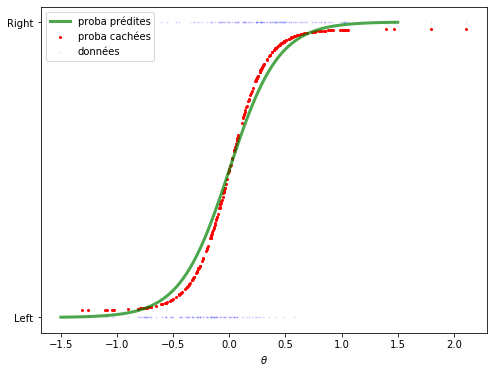

In [8]:
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();


## validation

loss= tensor(0.3393, grad_fn=<BinaryCrossEntropyBackward>)


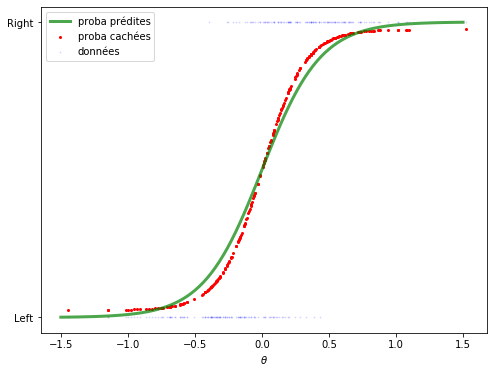

In [9]:
theta, p, y = get_data() # nouvelles données 

labels = torch.Tensor(y[:, None])
Theta = torch.Tensor(theta[:, None])
outputs = logistic_model(Theta)
loss = criterion(outputs, labels)
print('loss=', loss)
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();